In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import lmfit
import scipy as sp

In [2]:
def GRing(xy, A, X, Y, R, σ, C):
    r = np.sqrt((X-xy[0])**2 + (Y-xy[1])**2)
    return A * np.exp(-(R-r)**2 / (2*σ**2)) + C

In [3]:
trueparams = (1, 0.1, -0.3, 0.8, 0.2, 0.4)
numpoints = 501
gridmin = -2
gridmax = 2
gridratio = (gridmax - gridmin) / (numpoints - 1)
sidelist = np.linspace(gridmin, gridmax, numpoints)
xygrid = np.meshgrid(sidelist, sidelist)
ringlist = GRing(xygrid, *trueparams)
randfactor = 0.5
data = ringlist + randfactor * trueparams[0] * (np.random.random(ringlist.shape) - 0.5)

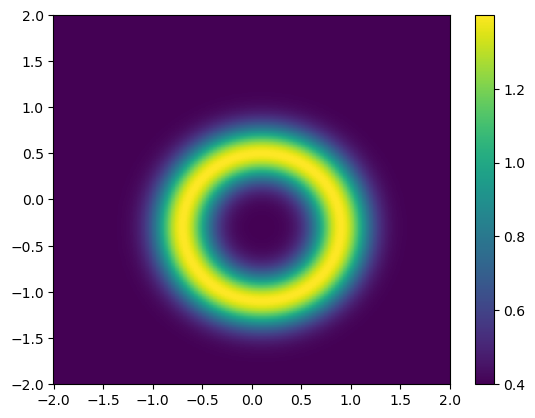

In [4]:
plt.pcolormesh(*xygrid, ringlist, shading='nearest')
plt.colorbar()

In [5]:
# Guess C from histogram features
hist = np.histogram(data.flatten(), bins=50)
drop = hist[1][int(np.argmax(np.abs(np.diff(hist[0]))))]
noise_width = drop - data.min()
Cguess = data.min() + noise_width/2

# Guess X, Y from photocenter
norm_data = data - Cguess # data.sum()/data.flatten().shape
Xguess = np.sum(xygrid[0] * norm_data) / np.sum(norm_data)
Yguess = np.sum(xygrid[1] * norm_data) / np.sum(norm_data)

# Guess R from distance between photocenter and brightest pixel
max_idx = np.unravel_index(np.argmax(data), data.shape)
xmax = xygrid[0][max_idx]
ymax = xygrid[1][max_idx]
Rguess = np.sqrt((Xguess-xmax)**2 + (Yguess-ymax)**2)

# Guess σ from FWHM of ring minus R
data1d = np.sum(data, axis=0)
halfmax = (data1d.max() - data1d.min()) / 2 + data1d.min()
datahalfmax = np.abs(data1d - halfmax)
pixFWHM = abs(np.argmin(datahalfmax) - np.argmin(datahalfmax[::-1]))
σguess = (pixFWHM * gridratio - 2 * Rguess) / 2.355

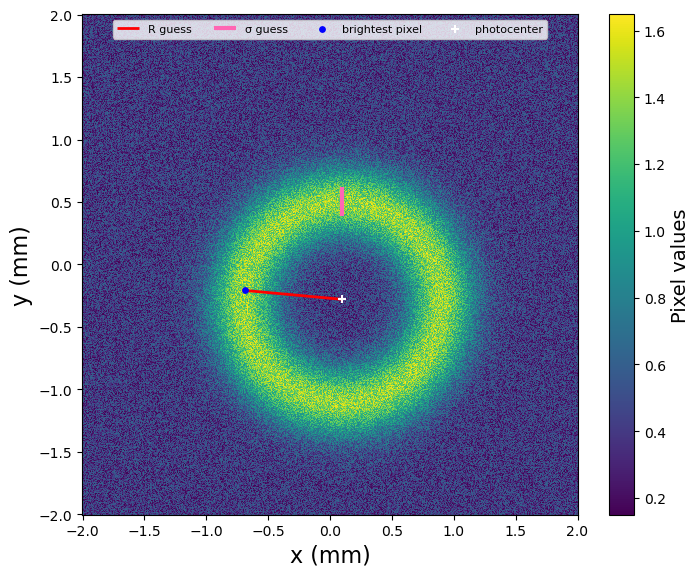

In [6]:
fig, ax = plt.subplots(figsize=(8,6.5))
plt.pcolormesh(*xygrid, data, shading='nearest')
# shading='nearest' centers squares on data points
cbar = plt.colorbar()
cbar.set_label('Pixel values', fontsize=14)

Rguessline = mc.LineCollection([[(Xguess, Yguess), (xmax, ymax)]],
                               colors=(1, 0, 0, 1), linewidths=2, label='R guess')
σguessline = mc.LineCollection([[(Xguess, Yguess + Rguess - σguess/2),
                                  (Xguess, Yguess + Rguess + σguess/2)]],
                               colors=(1, 0.4, 0.7, 1), linewidths=3, label='σ guess')
ax.add_collection(Rguessline)
ax.add_collection(σguessline)

plt.scatter([xmax], [ymax], color='blue', marker='o', s=15, zorder=10, label='brightest pixel')
plt.scatter([Xguess], [Yguess], color='white', marker='+', zorder=10, label='photocenter')

ax.legend(ncol=4, loc='upper center', fontsize=8)
ax.set_xlabel('x (mm)', fontsize=16)
ax.set_ylabel('y (mm)', fontsize=16);

In [7]:
GRmodel = lmfit.Model(GRing)
params = GRmodel.make_params()
params['A'].value = data.max()
params['X'].value = Xguess
params['Y'].value = Yguess
params['R'].value = Rguess
params['σ'].value = σguess
params['C'].value = Cguess

In [8]:
result = GRmodel.fit(data, xy=xygrid, params=params)
print(result.fit_report())

[[Model]]
    Model(GRing)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 251001
    # variables        = 6
    chi-square         = 5222.60475
    reduced chi-square = 0.02080760
    Akaike info crit   = -971979.496
    Bayesian info crit = -971916.897
    R-squared          = 0.80590974
[[Variables]]
    A:  1.00059102 +/- 0.00108789 (0.11%) (init = 1.649214)
    X:  0.09973347 +/- 3.4575e-04 (0.35%) (init = 0.09370283)
    Y: -0.30011602 +/- 3.4575e-04 (0.12%) (init = -0.2788324)
    R:  0.79949702 +/- 2.5684e-04 (0.03%) (init = 0.7849054)
    σ:  0.20005878 +/- 2.7173e-04 (0.14%) (init = 0.2302289)
    C:  0.40003652 +/- 3.5245e-04 (0.09%) (init = 0.3898834)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, σ) = -0.4216
    C(σ, C) = -0.3668
    C(R, σ) = -0.2365
    C(A, C) = -0.2291


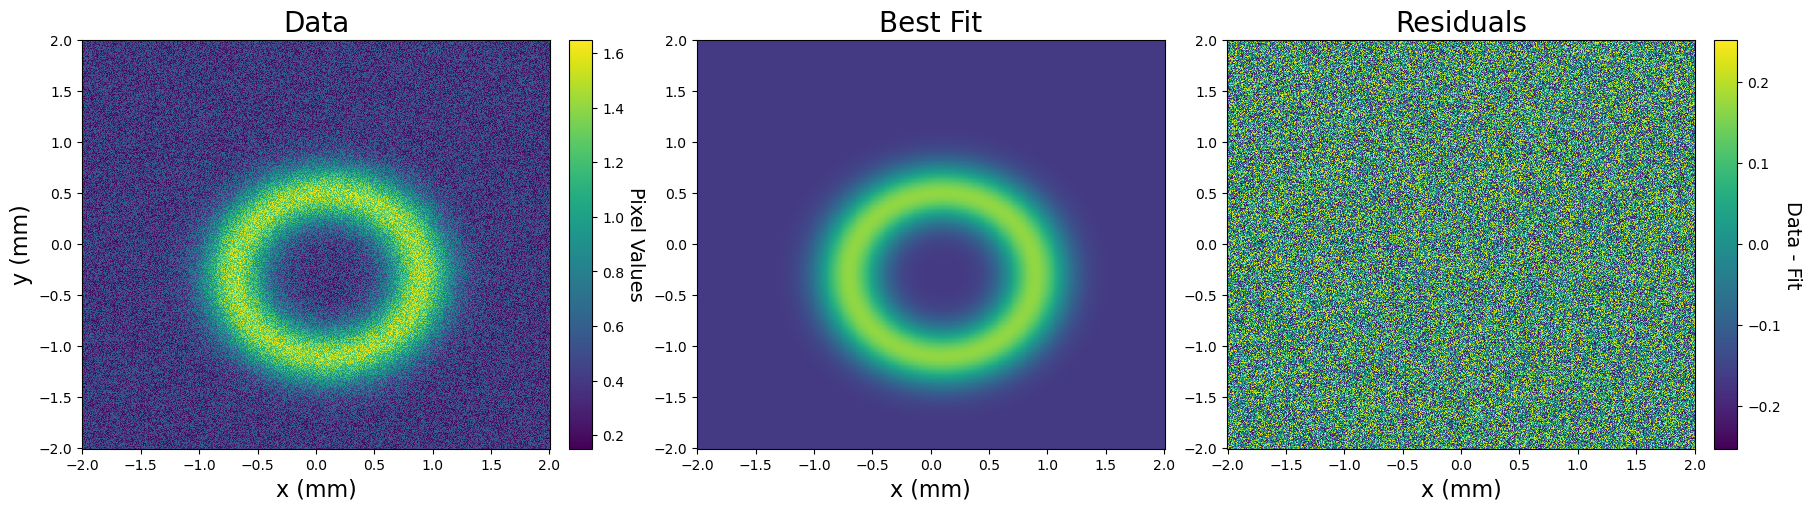

In [9]:
fitgrid = result.eval(xy=xygrid)
residgrid = data - fitgrid

fig, axs = plt.subplots(figsize=(18, 5), nrows = 1, ncols = 5, layout = 'constrained',
                            gridspec_kw = dict(width_ratios = (1, 0.05, 1, 1, 0.05)))
vmin = min(data.min(), fitgrid.min())
vmax = max(data.max(), fitgrid.max())
axs[0].pcolormesh(*xygrid, data, shading='nearest', vmin=vmin, vmax=vmax)
fit_c = axs[2].pcolormesh(*xygrid, fitgrid, shading='nearest', vmin=vmin, vmax=vmax)
fig.colorbar(fit_c, cax=axs[1])
resid_c = axs[3].pcolormesh(*xygrid, residgrid, shading='nearest')
fig.colorbar(resid_c, cax=axs[4])

axs[0].set_title('Data', fontsize=20)
axs[2].set_title('Best Fit', fontsize=20)
axs[3].set_title('Residuals', fontsize=20)

axs[0].set_ylabel('y (mm)', fontsize=16)
for ax in (axs[0], axs[2], axs[3]):
    ax.set_xlabel('x (mm)', fontsize=16)

axs[1].set_ylabel('Pixel Values', fontsize=14, rotation=270, labelpad=15)
axs[4].set_ylabel('Data - Fit', fontsize=14, rotation=270, labelpad=15)

plt.show()